In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
from src.utils import flatten_level_columns as flc
from src.utils import read_netmhcpan_results, get_filtered_df, filter_rank
from src.sequence_handling import AA_KEYS
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')
pal = sns.color_palette('hsv', n_colors=13)
pal = [pal[6], pal[9], pal[-1]]
sns.set_palette(pal)
mpl.rcParams['figure.dpi'] = 180
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

# old stuff

## cedar filtering fcts

In [53]:
def count_class(df):
    tmp = df.groupby('agg_label').count()
    display(tmp)
    return tmp

def get_top_HLA(df, n=10):
    hla_col = 'HLA' if 'HLA' in df.columns else 'mhc_allele name'
    pep_col = 'Peptide' if 'Peptide' in df.columns else 'epitope_description'
    tmp = ','.join([x.replace(':','').replace('*','').replace('HLA-','')\
              for x in df.groupby(hla_col)[[pep_col]].agg('count').sort_values(pep_col, ascending=False).head(n).index])
    print(tmp)
    return tmp

def query_ELIS(df):
    return df.query('`assay_method/technique` in ["ELISPOT", "ELISA"]').sort_values('epitope_description')

def keep_full_HLA(df):
    return df.query('`mhc_allele name`.str.contains(":")', engine = 'python')

def get_dupe_unique_df(df):
    """
    From the source df, get the unique (keeping first) AND the duplicates df, and the common indices
    """
    dup_df = df.loc[df.duplicated(subset='epitope_description', keep=False)].sort_values('epitope_description')
    unique_df = df.drop_duplicates(subset='epitope_description', keep ='first')
    common_indices = dup_df.index.join(unique_df.index, how = 'inner')
    return unique_df, dup_df, common_indices

def get_agg_label(dup_df):
    dup_df['label'] = dup_df['assay_qualitative measure'].apply(lambda x: 1 if 'Pos' in x else 0)
    agg_label = dup_df.groupby('epitope_description').agg({'label':"max"})
    gb = dup_df.groupby(['epitope_description', 'label']).agg({'label':"count"}).rename(columns={'label':'count'})
    return agg_label

def get_agg(dup_df):
    dup_df['label'] = dup_df['assay_qualitative measure'].apply(lambda x: 1 if 'Pos' in x else 0)
    
    gb = dup_df.groupby(['epitope_description', 'label']).agg({'label':"count"}).rename(columns={'label':'count'})#.reset_index()
    gb['percentage_pos'] = gb/gb.groupby(['epitope_description']).agg({'count':"sum"})
    agg = gb.reset_index().groupby(['epitope_description']).agg({'label':'max', 'percentage_pos':"max"}).rename(columns={'label':'agg_label'})
    agg.loc[agg['agg_label']==0, 'percentage_pos']=0
    agg['total'] = gb.reset_index().groupby('epitope_description').agg({'count':"sum"})
    return agg

def assign_agg_metrics(unique_df, agg_df, common_indices):
    unique_df['agg_label'] = unique_df['assay_qualitative measure'].apply(lambda x: 1 if 'Pos' in x else 0)
    unique_df['total_count'] = 1
    unique_df['percentage_pos'] = unique_df['agg_label']
    unique_df.loc[common_indices, 'agg_label'] = agg['agg_label'].values
    unique_df.loc[common_indices, 'total_count'] = agg['total'].values
    unique_df.loc[common_indices, 'percentage_pos'] = agg['percentage_pos'].values
    return unique_df

def get_top_hla(df, n=10):
    return df.groupby('HLA')['Peptide'].count().sort_values(ascending=False).head(n)


## init HP

In [2]:
scored_9mers = pd.concat([pd.read_csv(f'../output/9mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]])
scored_8mers = pd.concat([pd.read_csv(f'../output/8mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]])
scored_10mers = pd.concat([pd.read_csv(f'../output/10mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]])
scored_11mers = pd.concat([pd.read_csv(f'../output/11mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]])
scored_12mers = pd.concat([pd.read_csv(f'../output/12mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]])
scored = {9: scored_9mers,
          8: scored_8mers,
          10: scored_10mers,
          11: scored_11mers,
          12: scored_12mers}

KeyboardInterrupt: 

# Old cedar dump

## some hp stuff

Removing entries with X and saving to pep/df file for hobohm1
lst=[]
for k,v in scored.items():
    lst.append(v.loc[~(v['Peptide'].str.contains("X"))])

hp_no_x = pd.concat(lst)

hp_no_x.to_csv('../../../human_proteome_df.csv')
hp_no_x['Peptide'].to_csv('../../../human_proteome_df.pep', index=False, header=False)

scored_9mers.query('HLA=="HLA-A02:01" and EL_Rank<=0.1')['Peptide'].to_csv('A0201_rank01.txt', index=False, header=False)

## some len N checks and HLA checks

In [4]:
for x in scored_9mers.HLA.unique():
    print(f'{x}, N = {len(scored_9mers.query("HLA == @x and EL_Rank < 0.5"))}')

HLA-B35:01, N = 90530
HLA-B15:01, N = 100068
HLA-B07:02, N = 96024
HLA-A02:06, N = 106130
HLA-A02:01, N = 104519
HLA-A24:02, N = 90257
HLA-A03:01, N = 58403
HLA-B08:01, N = 120521
HLA-A01:01, N = 50742
HLA-B27:05, N = 102168
HLA-A11:01, N = 94623
HLA-B40:01, N = 77875


In [42]:
for k in scored.keys():
    print(k, len(scored[k]))

9 7850499
8 5735573
10 7340466
11 6975655
12 5069501


In [4]:
COLUMNS=['Peptide', 'HLA', 'agg_label', 'total_count', 'percentage_pos']
cedar = pd.read_csv('../data/cedar_filtered.csv', usecols = COLUMNS)#.drop(columns=['Unnamed: 0'])
cedar['len'] = cedar.Peptide.apply(len)
cedar

,Peptide,HLA,agg_label,total_count,percentage_pos,len
0,AAGIGILTV,HLA-A*02:01,1,14,0.928571,9
1,AAIAASRSV,HLA-C*12:03,0,1,0.000000,9
2,AAKAALEDF,HLA-C*16:01,0,1,0.000000,9
3,AAPAHSHAG,HLA-A*02:06,0,1,0.000000,9
4,AAPAHSHAV,HLA-A*02:06,0,1,0.000000,9
...,...,...,...,...,...,...
1682,YYILDKKEHFK,HLA-A*33:01,0,2,0.000000,11
1683,YYPPSQIAQL,HLA-A*24:02,1,1,1.000000,10
1684,YYSKNLNSF,HLA-A*24:02,1,1,1.000000,9
1685,YYSKNLNSFF,HLA-A*24:02,1,2,1.000000,10


## adding HP to cedar

In [27]:
cedar_hlas = [x for x in cedar.groupby('HLA')['Peptide'].count().sort_values(ascending=False).head(12).index]
hp_hlas = list(scored_9mers.HLA.unique())
common_hlas = [x.replace('*','') for x in cedar_hlas if x.replace('*','') in hp_hlas]
common_hlas

['HLA-A02:01',
 'HLA-A24:02',
 'HLA-A03:01',
 'HLA-B27:05',
 'HLA-A11:01',
 'HLA-B08:01',
 'HLA-A01:01',
 'HLA-A02:06',
 'HLA-B07:02',
 'HLA-B35:01',
 'HLA-B40:01']

In [54]:
hp_hlas = list(scored_9mers.HLA.unique())
for l in range(8,13):
    cedar_hlas = get_top_hla(cedar.query('len==@l'),10).index
    common_hlas = [x.replace('*','') for x in cedar_hlas if x.replace('*','') in hp_hlas]
    distinct_hlas = [x.replace('*','') for x in cedar_hlas if x.replace('*','') not in hp_hlas]
    print(f'len: {l}, \n\t{common_hlas}\n\t{distinct_hlas}')

len: 8, 
	['HLA-A02:01', 'HLA-A02:06', 'HLA-A11:01', 'HLA-B08:01', 'HLA-B15:01']
	['HLA-B18:01', 'HLA-B51:01', 'HLA-C14:03', 'HLA-C05:01', 'HLA-A30:01']
len: 9, 
	['HLA-A02:01', 'HLA-A24:02', 'HLA-B27:05', 'HLA-A03:01', 'HLA-B08:01', 'HLA-B07:02', 'HLA-A11:01', 'HLA-A02:06', 'HLA-A01:01', 'HLA-B35:01']
	[]
len: 10, 
	['HLA-A02:01', 'HLA-A03:01', 'HLA-A24:02', 'HLA-B27:05', 'HLA-A11:01', 'HLA-A01:01', 'HLA-B08:01', 'HLA-B07:02', 'HLA-B35:01']
	['HLA-A30:01']
len: 11, 
	['HLA-A02:01', 'HLA-A11:01', 'HLA-A03:01']
	['HLA-C12:03', 'HLA-A68:01', 'HLA-B44:03', 'HLA-C14:03', 'HLA-A68:02', 'HLA-A33:01', 'HLA-A31:01']
len: 12, 
	['HLA-A03:01', 'HLA-B07:02']
	[]


In [11]:
groupby = cedar.query("agg_label==1").groupby('len')['Peptide'].count()
samples = []
for l, count in zip(groupby.index, groupby.values):
    query = cedar.query('len==@l')
    neg = cedar.groupby(['agg_label','len'])['Peptide'].count().loc[(0,l)]
    pos = cedar.groupby(['agg_label','len'])['Peptide'].count().loc[(1,l)]
    n = 5*pos-neg
    print('len, pos, neg, n', l, pos, neg, n)
    samples.append(scored[l].sample(n, random_state=13))
samples = pd.concat(samples)
samples

len, pos, neg, n 8 15 46 29
len, pos, neg, n 9 436 661 1519
len, pos, neg, n 10 144 286 434
len, pos, neg, n 11 27 70 65
len, pos, neg, n 12 1 1 4


,Peptide,start_pos,uniprot_id,id_position,HLA,Ave,BA-score,BA_Rank,EL-score,EL_Rank,ID,NB,Pos,core,icore
1257954,VYTATVPE,162,P55285,P55285_162,HLA-A24:02,0.0005,0.0430,24.7321,0.0005,14.3000,PEPLIST,0,0,VYTATVPE-,VYTATVPE
55688,GVLEHILS,188,Q14691,Q14691_188,HLA-A02:06,0.0023,0.0865,36.8892,0.0023,18.1409,PEPLIST,0,0,GVLEHILS-,GVLEHILS
90374,KDDVEVVM,2717,Q8IVF4,Q8IVF4_2717,HLA-B40:01,0.0108,0.0630,13.0479,0.0108,3.4001,PEPLIST,0,0,KDD-VEVVM,KDDVEVVM
952348,YVVLHASR,178,Q9UKU6,Q9UKU6_178,HLA-A11:01,0.0018,0.1066,12.0585,0.0018,9.3815,PEPLIST,0,0,YVV-LHASR,YVVLHASR
401468,ISRTPVLM,144,Q9H3K2,Q9H3K2_144,HLA-B07:02,0.0062,0.1069,10.3799,0.0062,6.4225,PEPLIST,0,0,ISRTP-VLM,ISRTPVLM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273964,AHLYNNEEQVG,51,Q04828,"P14410_647,O43451_671,Q2M2H8_1523",HLA-A02:01,0.0131,0.1540,14.1657,0.0131,5.9223,PEPLIST,0,0,ALYNNEEQV,AHLYNNEEQV
353978,RFKGRRHLHYLK,288,Q6V1P9,Q6V1P9_288,HLA-B27:05,0.0789,0.5985,0.2481,0.0789,2.0927,PEPLIST,0,0,RRRHLHYLK,RFKGRRHLHYLK
819265,SFNGSWRVQGIL,249,Q5SGD2,Q5SGD2_249,HLA-A24:02,0.0009,0.1250,6.4794,0.0009,11.2500,PEPLIST,0,0,SFNGSWRVL,SFNGSWRVQGIL
386683,RKLPVPQGPNPV,665,O94829,O94829_665,HLA-B27:05,0.0025,0.1390,9.4017,0.0025,9.5018,PEPLIST,0,0,RKLPVPQGV,RKLPVPQGPNPV


In [84]:
samples['agg_label'] = 0
samples['total_count'] = 1
samples['percentage_pos'] = 0
samples['len'] = samples['Peptide'].apply(len)
cedar['dataset']='cedar'
samples['dataset']='hp'

samples.to_csv('../data/hp_neg_samples.csv')
concat = pd.concat([cedar, samples[cedar.columns]])
concat['HLA']=concat['HLA'].apply(lambda x: x.replace('*',''))
concat.to_csv('../data/cedar_posneg_hp.csv', index=False)

concat[['Peptide', 'agg_label']].to_csv('../data/cedar_posneg_hp.pep', sep='\t',
                                               index=False,header=False)

## sub sampling cedar neg

In [8]:
len(cedar.query('agg_label==0 and total_count>1')), len(cedar.query('agg_label==0 and total_count<=1'))

(154, 910)

In [28]:
count=cedar.query('agg_label==1').groupby('len').count()[['Peptide']]
count['ratio'] = count['Peptide'].apply(lambda x: x/len(cedar.query('agg_label==1')))
count

,Peptide,ratio
len,,
8,15,0.024077
9,436,0.699839
10,144,0.231140
11,27,0.043339
12,1,0.001605


In [33]:
for seed in range(10):
    gb =cedar.query('agg_label==0 and total_count<=1').sample(154, random_state=seed).groupby('len').count()[['Peptide']]
    gb['ratio'] = gb['Peptide'].apply(lambda x: x/154)
    print('\n\t',seed, '\n',gb)


	 0 
      Peptide     ratio
len                   
8          8  0.051948
9         86  0.558442
10        50  0.324675
11         9  0.058442
12         1  0.006494

	 1 
      Peptide     ratio
len                   
8         11  0.071429
9         97  0.629870
10        39  0.253247
11         7  0.045455

	 2 
      Peptide     ratio
len                   
8          6  0.038961
9         91  0.590909
10        48  0.311688
11         9  0.058442

	 3 
      Peptide     ratio
len                   
8          6  0.038961
9        104  0.675325
10        33  0.214286
11        10  0.064935
12         1  0.006494

	 4 
      Peptide     ratio
len                   
8          6  0.038961
9         93  0.603896
10        42  0.272727
11        13  0.084416

	 5 
      Peptide     ratio
len                   
8          7  0.045455
9         97  0.629870
10        42  0.272727
11         8  0.051948

	 6 
      Peptide     ratio
len                   
8          9  0.058442
9       

In [39]:
cedar_subsampled = pd.concat([cedar.query('agg_label==1'), cedar.query('agg_label==0 and total_count <= 1').sample(154, random_state=8)])
cedar_subsampled.to_csv('../data/cedar_subsampled_negs.csv', index=False)
cedar_subsampled[['Peptide', 'agg_label']].to_csv('../data/cedar_subsampled_negs.pep', sep='\t', index=False, header=False)

In [38]:
refined

,epitope_epitope id,epitope_description,epitope_starting position,epitope_ending position,epitope_antigen name,epitope_parent protein,related object_epitope relationship,related object_description,related object_parent protein,mhc_allele name,mhc_allele evidence code,assay_method/technique,agg_label,total_count,percentage_pos,len
0,1852488,AEVDQDGVVM,NaN,NaN,NaN,NaN,neo-epitope,AEVDEDGVVM,Neurogenic locus notch homolog protein 4,HLA-B*44:03,Cited reference,ELISA,0,2,0.000000,10
1,1852507,AILLGAEEK,NaN,NaN,NaN,NaN,neo-epitope,AKLLGAEEK,Epidermal growth factor receptor,HLA-A*11:01,Cited reference,ELISA,0,2,0.000000,9
2,1852513,AITSPKANK,NaN,NaN,NaN,NaN,neo-epitope,AIKELREATSPKANK,Epidermal growth factor receptor,HLA-A*11:02,Cited reference,ELISA,0,2,0.000000,9
3,1852603,AQPAVQSAF,NaN,NaN,NaN,NaN,neo-epitope,AQAAVQSAF,Cyclin-dependent kinase 13,HLA-A*02:06,Cited reference,ELISA,0,2,0.000000,9
4,1852610,ARLPVGAYEV,NaN,NaN,NaN,NaN,neo-epitope,ALLPVGAYEV,Aquaporin-12B,HLA-A*02:01,Cited reference,ELISA,0,2,0.000000,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,859644,YVDFREYEYY,NaN,NaN,NaN,NaN,neo-epitope,YVDFREYEY,Receptor-type tyrosine-protein kinase FLT3,HLA-A*01:01,T cell assay -Mismatched MHC molecules,ELISPOT,1,4,0.750000,10
773,1851946,YVVPGSPCL,NaN,NaN,NaN,NaN,neo-epitope,SVVPGSPCL,Tensin-1,HLA-C*03:03,MHC binding assay,ELISPOT,1,3,0.666667,9
774,474330,YYPPSQIAQL,NaN,NaN,NaN,NaN,neo-epitope,YYPPSQIAQL,Polyadenylate-binding protein 1,HLA-A*24:02,MHC binding prediction,ELISPOT,1,1,1.000000,10
775,607022,YYSKNLNSF,NaN,NaN,NaN,NaN,neo-epitope,YYSKNLNSS,Protein MMS22-like,HLA-A*24:02,MHC binding prediction,ELISPOT,1,1,1.000000,9


# new export 01-07-22

In [2]:
def find_rank_HLA(row, df_xls, dummy = None):
    hla = row['HLA']
    pep = row['Peptide']
    colpp = ('base', 'Peptide')
    colhl = (f'{hla}', 'EL_Rank')
    tmp=df_xls.iloc[row.name]
    assert tmp[colpp]==pep, f'{tmp[colpp]},{pep}'
    return tmp[colhl]

## initial checks & rescoring the peps with NetMHCpan

In [45]:
neo_full = pd.read_excel('../data/raw_exports/neo_JUN2022_full_res.xlsx', sheet_name = 'full')
neo_short = pd.read_excel('../data/raw_exports/neo_JUN2022_full_res.xlsx', sheet_name = 'short')
neoepi = pd.read_excel('../data/raw_exports/neo_JUN2022_full_res.xlsx', sheet_name = 'epitopes')
init_len = len(neoepi)
# some re-checking etc.
neoepi.rename(columns={'Epitope_Description':'Peptide', 'MHC_Allele Name':'HLA'}, inplace=True)
neoepi['total_count'] = neoepi['responses'].apply(lambda x: len(x.split(',')))
neoepi['percentage_pos'] = (neoepi['responses'].apply(lambda x: sum([1 for x in x.split(',') if 'Positive' in x]))/neoepi['total_count'])
neoepi['agg_label']=neoepi['label'].apply(lambda x: 1 if x=='Positive' else 0)
neoepi['len'] = neoepi['Peptide'].apply(len)
# Keeping only lengths in [8,12]
neoepi = neoepi.query('len>=8 and len<=12')
# dropping bs characters
neoepi.drop(index=neoepi.loc[neoepi['Peptide'].apply(lambda x: any([z for z in x if z not in AA_KEYS]))].index, inplace=True)
# Dropping MHC-II peptides
neoepi = neoepi.query('not HLA.str.contains("D")', engine='python')
# Dropping HLAs which only have negative peptides; Having only positive peptides for a given allele is fine because we can add human proteome as negs with predicted binding
hlas_to_keep = [x for x in neoepi.query('label=="Positive"').HLA.unique() if 'D' not in x]
neoepi = neoepi.query('HLA in @hlas_to_keep')
print(f'Before: {init_len}, After: {len(neoepi)}')
neoepi.HLA = neoepi.HLA.apply(lambda x: x.replace('*',''))
neoepi.to_csv('../data/cedar_neoepi_220701.csv', index=False)
display(neoepi.head())

Before: 3928, After: 3480


,Peptide,HLA,PMIDs,responses,label,total_count,percentage_pos,agg_label,len
0,AAAAAAQQIQV,HLA-B07:02,27198675,Negative,Negative,1,0.0,0,11
1,AAAAQQIQV,HLA-A02:01,27198675,Negative,Negative,1,0.0,0,9
2,AAAAQQIQV,HLA-B07:02,27198675,Negative,Negative,1,0.0,0,9
3,AAFIWIISM,HLA-B35:01,27198675,Negative,Negative,1,0.0,0,9
4,AAHFTVLLY,HLA-A11:01,31511069,Negative,Negative,1,0.0,0,9


In [76]:
' '.join([x.replace('*','') for x in hlas_to_keep])

'HLA-B40:02 HLA-B44:03 HLA-B44:08 HLA-B44:02 HLA-A02:01 HLA-A11:01 HLA-A03:01 HLA-A11:02 HLA-B07:02 HLA-A02:06 HLA-B15:01 HLA-C12:03 HLA-C07:02 HLA-A02:05 HLA-A24:02 HLA-A30:01 HLA-A68:02 HLA-C14:03 HLA-B51:01 HLA-A25:01 HLA-B18:01 HLA-B40:01 HLA-C06:02 HLA-B08:01 HLA-A26:01 HLA-B27:05 HLA-A31:01 HLA-B35:01 HLA-A29:02 HLA-C05:01 HLA-A02:24 HLA-C03:04 HLA-A02:03 HLA-B56:01 HLA-B39:01 HLA-C03:03 HLA-C08:02 HLA-A02:11 HLA-C15:02 HLA-B37:01 HLA-B38:01 HLA-A68:01 HLA-C12:02 HLA-A33:01 HLA-A01:01 HLA-C01:02 HLA-B13:02 HLA-C07:01 HLA-A30:02 HLA-B52:01 HLA-A02:10 HLA-B39:06 HLA-B35:03 HLA-A69:01 HLA-B41:02 HLA-B57:01 HLA-A03:02 HLA-A02:02 HLA-C14:02 HLA-B54:01 HLA-B37:04 HLA-B49:01 HLA-C04:01'

In [183]:
# Exporting results for NetMHCpan, then rereading the xls results
neoepi['Peptide'].to_csv('../data/cedar_neoepitope_220701.pep', index=False, header=False)
# rereading and getting the best predicted HLA
neoepi_xls = read_netmhcpan_results('../data/cedar_neoepitope_220701.pep.xls')
best_xls = get_filtered_df(filter_rank(neoepi_xls, 'EL_Rank'), neoepi_xls)
# Renaming for merging
best_xls.rename(columns={'HLA':'pred_HLA',
                         'EL_rank':'pred_EL_rank',
                         'EL_score':'pred_EL_score'}, inplace=True)


In [256]:
# finding EL rank for True HLA as well
neoepi.reset_index(inplace=True, drop=True)
neoepi['trueHLA_EL_rank']=neoepi.apply(find_rank_HLA, args=(neoepi_xls, _), axis=1)
neoepi_scored=neoepi.merge(best_xls.drop(columns=['Peptide']), left_index=True,right_index=True)
neoepi_scored.to_csv('../data/cedar_neoepitope_220701_scored.csv', index=False)

## checking peps in old vs new dataset

In [17]:
old_peps = cedar_old.Peptide.values
# flc == flatten level columns
old_raw = flc(pd.read_csv('../data/raw_exports/epitope_export_mhc1_TCR-MHC_220510.csv', header = [0,1]))
old_raw.query('epitope_description in @old_peps').to_csv('../data/raw_exports/220510_CEDAR_epitope_exports_mhc1_TCR.csv')

In [5]:
neoepi_scored = pd.read_csv('../data/cedar_neoepitope_220701_scored.csv')
cedar_old = pd.read_csv('../data/cedar_netmhc_scored.csv')
old_peps = cedar_old.Peptide.values
new_peps = neoepi_scored.Peptide.values
not_in_new = [x for x in old_peps if x not in new_peps]
cat = pd.concat([cedar_old.query('Peptide not in @new_peps')[['Peptide', 'HLA', 'total_count', 'len', 'agg_label','percentage_pos']],
                 neoepi_scored[['Peptide', 'HLA', 'total_count', 'len', 'agg_label','percentage_pos']]])
neo_full = pd.read_excel('../data/raw_exports/neo_JUN2022_full_res.xlsx', sheet_name = 'full')
neo_epi = pd.read_excel('../data/raw_exports/neo_JUN2022_full_res.xlsx', sheet_name = 'epitopes')

cat['Peptide'].to_csv('../data/cedar_all.pep', index=False,header=False)
len(neo_full.query('Epitope_Description=="AAGIGILTV"')), len(neo_epi.query('Epitope_Description=="AAGIGILTV"'))

(0, 0)

In [69]:
display(cat.groupby('agg_label').count())
cat['Peptide'].to_csv('../data/cedar_all.pep', index=False,header=False)
print(len(cat.query('agg_label==1').Peptide.unique()))

,Peptide,HLA,total_count,len,percentage_pos
agg_label,,,,,
0,3187,3187,3187,3187,3187
1,969,969,969,969,969


954


In [112]:
# re-reading and cat the old/new and resetting index to match the one in XLS
cedar_old = pd.read_csv('../data/cedar_netmhc_scored.csv')
old_peps = cedar_old.Peptide.values
new_peps = neoepi_scored.Peptide.values
not_in_new = [x for x in old_peps if x not in new_peps]
cat = pd.concat([cedar_old.query('Peptide not in @new_peps')[['Peptide', 'HLA', 'total_count', 'len', 'agg_label','percentage_pos']],
                 neoepi_scored[['Peptide', 'HLA', 'total_count', 'len', 'agg_label','percentage_pos']]])
cat.reset_index(inplace=True, drop = True)

In [117]:
cat['Peptide'].to_csv('../../../nnalign/data/cedar_concat.pep', index=False, header=False)
# Exporting results for NetMHCpan, then rereading the xls results
# rereading and getting the best predicted HLA
cat_xls = read_netmhcpan_results('../data/cedar_concat.pep.xls')
best_xls = get_filtered_df(filter_rank(cat_xls, 'EL_Rank'), cat_xls)
# Renaming for merging
best_xls.rename(columns={'HLA':'pred_HLA',
                         'EL_rank':'pred_EL_rank',
                         'EL_score':'pred_EL_score'}, inplace=True)
# finding EL rank for True HLA as well
hlas = cat.query('agg_label==1')['HLA'].unique()
cat = cat.query('HLA in @hlas')
cat['trueHLA_EL_rank']=cat.apply(find_rank_HLA, args=(cat_xls.loc[cat.index], _), axis=1)

In [ ]:
cat.to_csv('../data/cedar_concat_scored.csv', index=False)

## quick HLA and ranks checks

In [2]:
neoepi_scored=pd.read_csv('../data/cedar_neoepitope_220701_scored.csv')

In [211]:
from src.utils import display_side
correct = neoepi_scored.loc[neoepi_scored['HLA']==neoepi_scored['pred_HLA']][['Peptide', 'HLA', 'pred_HLA', 'pred_EL_rank']]
correct_supertype = neoepi_scored.loc[neoepi_scored.apply(lambda x: x['HLA'][:7]==x['pred_HLA'][:7], axis=1)]
wrong = neoepi_scored.loc[neoepi_scored['HLA']!=neoepi_scored['pred_HLA']][['Peptide', 'HLA', 'pred_HLA', 'pred_EL_rank', 'trueHLA_EL_rank']]
print(f"CEDAR:\nAmount of correctly predicted HLAs (full reso):{len(correct)/len(neoepi_scored):.3%}")
print(f"Amount of correctly predicted HLAs (supertype):{len(correct_supertype)/len(neoepi_scored):.3%}")


print(f"Amount of total peptides:\t{len(neoepi_scored)}\n"\
      f"Amount of correct HLA (fullres):{len(correct)}\n"\
      f"Amount of correct supertypes:\t{len(correct_supertype)}\n"\
      f"Amount of wrong (fullres):\t{len(wrong)}")
display_side(correct.sample(6, random_state=13), wrong.sample(6, random_state=13))

CEDAR:
Amount of correctly predicted HLAs (full reso):24.826%
Amount of correctly predicted HLAs (supertype):48.636%
Amount of total peptides:	3738
Amount of correct HLA (fullres):928
Amount of correct supertypes:	1818
Amount of wrong (fullres):	2810


Peptide 
 HLA 
 pred_HLA 
 pred_EL_rank 
 
 
 
 
 2542 
 RPRCLCTAV 
 HLA-B07:02 
 HLA-B07:02 
 0.1937 
 
 
 2052 
 MLSSNVINF 
 HLA-B15:01 
 HLA-B15:01 
 0.3065 
 
 
 1900 
 LRFSIIEEF 
 HLA-B27:05 
 HLA-B27:05 
 0.0153 
 
 
 1606 
 KTYETTLEK 
 HLA-A11:01 
 HLA-A11:01 
 0.0018 
 
 
 1736 
 LLFAPEYGPK 
 HLA-A03:01 
 HLA-A03:01 
 0.7274 
 
 
 1832 
 LMRDHMPPV 
 HLA-A02:03 
 HLA-A02:03 
 0.0817 
 
 
 
 
 
 
 Peptide 
 HLA 
 pred_HLA 
 pred_EL_rank 
 trueHLA_EL_rank 
 
 
 
 
 2420 
 RIAQCFLRV 
 HLA-A02:01 
 HLA-B13:02 
 0.7737 
 1.2625 
 
 
 889 
 GLMSNTPTPR 
 HLA-A11:01 
 HLA-A03:02 
 0.815 
 2.2515 
 
 
 821 
 FWLFWGLTYI 
 HLA-A02:01 
 HLA-A02:03 
 0.4925 
 0.6774 
 
 
 857 
 GIPENSFNV 
 HLA-A02:01 
 HLA-A02:10 
 0.1622 
 0.3659 
 
 
 1905 
 LRNSGGEVF 
 HLA-B27:05 
 HLA-C07:01 
 0.1299 
 0.4387 
 
 
 721 
 FPLTASKVL 
 HLA-B35:01 
 HLA-B35:03 
 0.0067 
 0.0732

In [381]:
df = pd.read_csv('../data/cedar_neoepitope_220701_scored.csv')
len(df), len(df.query('trueHLA_EL_rank>20'))
ratios = {x:y for x,y in zip([8,9,10,11,12],df.groupby('len').count()['Peptide'].values/len(df))}

(-2.0, 18.0)

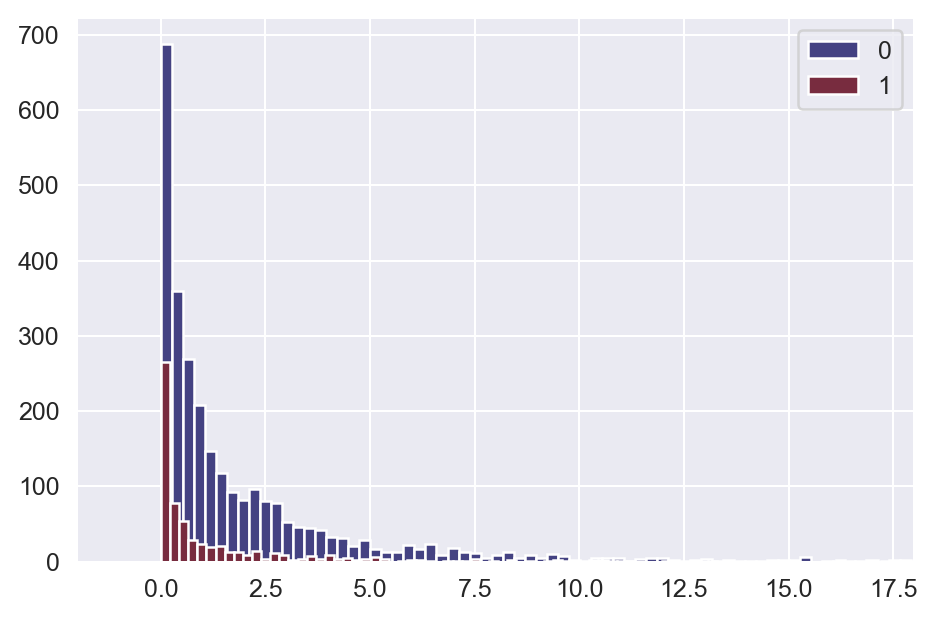

In [394]:
sns.set_palette('icefire', n_colors=2)
f,a=plt.subplots(figsize=(6,4))
df.groupby('agg_label')['trueHLA_EL_rank'].hist(bins=200,ax=a, legend=True)
a.set_xlim([-2, 18])

In [400]:
from scipy.stats import mannwhitneyu, levene, wilcoxon

In [398]:
ranks_negs = df.query('agg_label==0')['trueHLA_EL_rank'].values
ranks_pos = df.query('agg_label==1')['trueHLA_EL_rank'].values

In [401]:
levene(ranks_negs, ranks_pos)
mannwhitneyu(ranks_negs,ranks_pos) 
wilcoxon(ranks_negs,ranks_pos) 

ValueError: The samples x and y must have the same length.

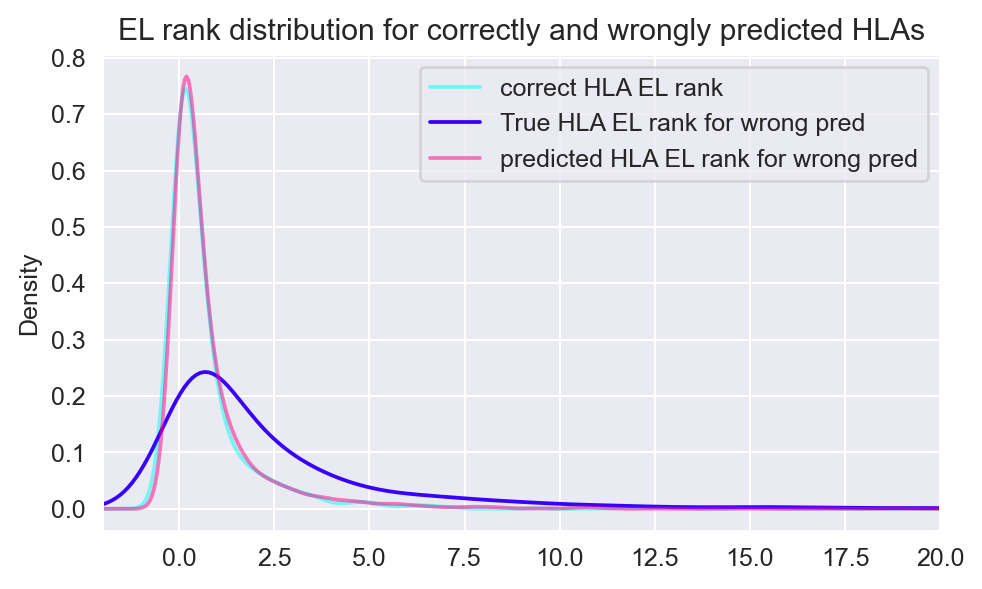

In [241]:
f,a = plt.subplots(1,1, figsize=(6,3.5))
correct['pred_EL_rank'].plot(kind='kde',ax=a, label='correct HLA EL rank', alpha=0.5)
wrong['trueHLA_EL_rank'].plot(kind='kde',ax=a, label = 'True HLA EL rank for wrong pred')
wrong['pred_EL_rank'].plot(kind='kde', ax=a, label = 'predicted HLA EL rank for wrong pred', alpha=0.5)
a.set_xlim([-2,20])
a.set_title('EL rank distribution for correctly and wrongly predicted HLAs')
a.legend()

## old

## saving datasets to pep for nnalign

In [3]:
cat = pd.read_csv('../data/cedar_concat_scored.csv')

In [257]:
neoepi_scored[['Peptide', 'agg_label']].to_csv('../../../nnalign/data/cedar_neoepitope_220701_scored.pep', 
                                               sep='\t',index=False, header=False)

In [18]:
neoepi_refined = pd.concat([neoepi_scored.query('agg_label==1'), neoepi_scored.query('agg_label==0 and total_count>1')])
neoepi_refined[['Peptide', 'agg_label']].to_csv('../../../nnalign/data/cedar_neoepitope_220701_scored_refined.pep',
                                                sep = '\t', index=False, header=False)

In [132]:
cat[['Peptide', 'agg_label']].to_csv('../../../nnalign/data/cedar_concat_scored.pep', 
                                     sep = '\t', index=False, header=False)

## Adding HP